根据不同的edge weights进行ClusterONE聚类，同时分析不同聚类结果的jaccard index

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
predict = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/gene_model.preds.pkl')

In [3]:
edges = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_cosine/model_0.pkl')

edges = edges[['A', 'B', 'cosim']].copy()

lt = predict[predict['type']=='literature']['entry'].tolist()
edges.loc[(edges['A'].isin(lt))&(edges['B'].isin(lt)), 'type'] = 1
edges['type'] = edges['type'].fillna(0).astype(int)

In [4]:
def mean_pred(row):
    a, b = row['A'], row['B']
    pred_a, pred_b = predict[predict['entry']==a]['pred'].item(), \
                        predict[predict['entry']==b]['pred'].item()
    return np.mean([pred_a, pred_b])

In [9]:
from multiprocessing.pool import Pool
pool = Pool(processes=8)
para = [e for _, e in edges.iterrows()]
hh = pool.map(mean_pred, para)
pool.close()
pool.join()

In [11]:
edges['mean.pred'] = hh

In [5]:
edges.loc[edges['cosim'] < 0, 'cosim'] = 0
edges.loc[edges['cosim'] > 1, 'cosim'] = 1

In [19]:
# for c in ['cosim', 'type', 'mean.pred']:
#     tmp = edges[['A', 'B', c]].copy()
#     tmp.to_csv(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_list_{c}.txt', sep='\t', index=None, header=None)

In [6]:
phasep_df = pd.read_pickle('./data/Label/human.condensate-formation.proteins-v1.pkl')
lt = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'])
dp = set(phasep_df[phasep_df['source']=='deepphase']['uniprot_entry'])
dp = dp - lt
pr = set(phasep_df[phasep_df['source']=='phasepred']['uniprot_entry'])
pr = pr - dp - lt

In [120]:
df1 = edges[['A', 'cosim']].copy()
df2 = edges[['B', 'cosim']].copy()
df1.columns = [0, 'cosim']
df2.columns = [0, 'cosim']
df3 = pd.concat([df1, df2]).groupby(0).mean().reset_index()

In [122]:
df3.loc[df3[0].isin(lt), 'type'] = 'lit'
df3['type'] = df3['type'].fillna('non-ps')

In [128]:
val1 = df3[df3['type']=='lit']['cosim'].values
val2 = df3[df3['type']!='lit']['cosim'].values
from scipy.stats import mannwhitneyu
mannwhitneyu(val1, val2, alternative='greater')

MannwhitneyuResult(statistic=8596774.5, pvalue=1.591277280280006e-171)

In [129]:
cl_cosim = pd.read_csv('./outputs/INTEGRATE_unweight_ProSE80d_mcc/cl.cosim.csv')
cl_unwig = pd.read_csv('./cl.jaccard.unweighted.csv')
cl_rawig = pd.read_csv('./cl.jaccard.raweighted.csv')

In [130]:
genes = predict['entry']
pos = set(predict['entry'].tolist()) & lt

In [131]:
def phasep_enrich(x):
    mem = set(x.split(' '))
    a = pos & mem
    b = mem - pos
    c = pos - mem
    d = set(genes.tolist()) - pos - mem
    from scipy.stats import fisher_exact
    _, p = fisher_exact([[len(a), len(b)], [len(c), len(d)]], alternative='greater')
    return p

In [132]:
cl_cosim['enr.pval'] = cl_cosim['Members'].apply(lambda x: phasep_enrich(x))
cl_unwig['enr.pval'] = cl_unwig['Members'].apply(lambda x: phasep_enrich(x))
cl_rawig['enr.pval'] = cl_rawig['Members'].apply(lambda x: phasep_enrich(x))
# cl_pred['enr.pval'] = cl_pred['Members'].apply(lambda x: phasep_enrich(x))
# cl_type['enr.pval'] = cl_type['Members'].apply(lambda x: phasep_enrich(x))

In [134]:
pspred = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')

In [140]:
cl_cosim.sort_values(by='enr.pval')['Members'][4]

'P62826 Q8NFH5 P63279 P55735 P18754 P61769 Q9BW19 P49790 Q14974 P49792 P57740 Q15398 Q5SRE5 Q69YH5 P0DJD0 P52948 P78406 P12270 Q9NRG9 Q9BVL2 O75694 Q99567 Q92621 Q9BW27 Q8N1F7 P61956 Q9P0U3 Q12769 Q8WUM0 Q96SK2 A8CG34 O14715 P63165 E9PJ23 Q8NFH3 P0DJD1 P35658 Q9BXS6 P46060 Q8TEM1 A6NKT7 P02818 Q96EE3 Q8NFH4'

In [189]:
pval_cutoff = .01

num1 = cl_cosim[cl_cosim['enr.pval'] < pval_cutoff].shape[0]

num2 = cl_cosim[cl_cosim['enr.pval'] < pval_cutoff].shape[0] / cl_cosim.shape[0]

num3 = cl_cosim[cl_cosim['enr.pval'] < pval_cutoff]['Size'].mean()

num4 = cl_cosim[cl_cosim['enr.pval'] >= pval_cutoff]['Size'].mean()

print('Cosine-weighted PPIN clustering results')
print('PS-enriched cluster, Number : {}, Ratio: {:.4f}, Average size: {:.2f}'.format(num1, num2, num3))
print('PS-not enriched cluster, Average size: {:.2f}'.format(num4))

num1 = cl_unwig[cl_unwig['enr.pval'] < pval_cutoff].shape[0]

num2 = cl_unwig[cl_unwig['enr.pval'] < pval_cutoff].shape[0] / cl_unwig.shape[0]

num3 = cl_unwig[cl_unwig['enr.pval'] < pval_cutoff]['Size'].mean()

num4 = cl_unwig[cl_unwig['enr.pval'] >= pval_cutoff]['Size'].mean()

print('\nUnweighted PPIN clustering results')
print('PS-enriched cluster, Number : {}, Ratio: {:.4f}, Average size: {:.2f}'.format(num1, num2, num3))
print('PS-not enriched cluster, Average size: {:.2f}'.format(num4))

num1 = cl_rawig[cl_rawig['enr.pval'] < pval_cutoff].shape[0]

num2 = cl_rawig[cl_rawig['enr.pval'] < pval_cutoff].shape[0] / cl_rawig.shape[0]

num3 = cl_rawig[cl_rawig['enr.pval'] < pval_cutoff]['Size'].mean()

num4 = cl_rawig[cl_rawig['enr.pval'] >= pval_cutoff]['Size'].mean()

print('\nRandom weighted PPIN clustering results')
print('PS-enriched cluster, Number : {}, Ratio: {:.4f}, Average size: {:.2f}'.format(num1, num2, num3))
print('PS-not enriched cluster, Average size: {:.2f}'.format(num4))

Cosine-weighted PPIN clustering results
PS-enriched cluster, Number : 64, Ratio: 0.0201, Average size: 21.95
PS-not enriched cluster, Average size: 6.32

Unweighted PPIN clustering results
PS-enriched cluster, Number : 33, Ratio: 0.0317, Average size: 14.09
PS-not enriched cluster, Average size: 6.05

Random weighted PPIN clustering results
PS-enriched cluster, Number : 50, Ratio: 0.0102, Average size: 13.90
PS-not enriched cluster, Average size: 5.65


In [104]:
CL1 = cl_type
CL2 = cl_pred

from itertools import product
n1, n2 = [i for i in range(CL1.shape[0])], [j for j in range(CL2.shape[0])]
clst_pairs = [m for m in product(n1, n2)]

def calc_jaccard(x1, cl, idx2):
    x2 = cl['Members'][idx2]
    x1, x2 = set(x1.split(' ')), set(x2.split(' '))
    intersect = x1 & x2
    union = x1 | x2
    jaccard = len(intersect) / len(union)
    return jaccard

# calc_jaccard(CL1['Members'][0], CL2, 2)

cl_mems = CL1[['Cluster', 'Members']].copy()
for idx in tqdm(n2):
    cl_mems[idx] = cl_mems['Members'].apply(lambda x: calc_jaccard(x, CL2, idx))

max_jaccards = list()
for _, i in tqdm(cl_mems.iterrows()):
    max_jaccard = np.max(i.iloc[2:])
    max_jaccards.append(max_jaccard)

CL1['max.jaccard'] = max_jaccards

# CL1['max.jaccard'].mean()

In [4]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [5]:
edges = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_cosine/model_0.pkl')

edges = edges[['A', 'B', 'cosim']].copy()

lt = predict[predict['type']=='literature']['entry'].tolist()
edges.loc[(edges['A'].isin(lt))&(edges['B'].isin(lt)), 'type'] = 1
edges['type'] = edges['type'].fillna(0).astype(int)

edges.loc[edges['cosim'] < 0, 'cosim'] = 0
edges.loc[edges['cosim'] > 1, 'cosim'] = 1

In [6]:
phasep_df = pd.read_pickle('./data/Label/human.condensate-formation.proteins-v1.pkl')
lt = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'])
dp = set(phasep_df[phasep_df['source']=='deepphase']['uniprot_entry'])
dp = dp - lt
pr = set(phasep_df[phasep_df['source']=='phasepred']['uniprot_entry'])
pr = pr - dp - lt

In [7]:
pairwise_cosim = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/pairwise_cosine/model_0.pkl')

In [8]:
# interactions between phase-separated proteins
df1 = edges[edges['type']==1].reset_index(drop=True)

In [9]:
num_neg = len(df1) * 3
from itertools import combinations
lt_ppin = set(predict['entry'].tolist()) & lt
comb = pd.DataFrame([i for i in combinations(lt_ppin, 2)])
comb.columns = ['A', 'B']
comb[0] = np.sort(comb[['A', 'B']].values).sum(axis=1)

In [10]:
l1 = np.sort(df1[['A', 'B']].values).sum(axis=1).tolist()
comb.loc[comb[0].isin(l1), 'type'] = 'pos'
comb['type'] = comb['type'].fillna('neg')

In [11]:
# df2 = comb[comb['type']=='neg'].sample(num_neg, random_state=0).reset_index(drop=True)
df2 = comb[comb['type']=='neg'].reset_index(drop=True)

In [12]:
from tqdm import tqdm
hh = list()
for _, i in tqdm(df2.iterrows()):
    a, b = i['A'], i['B']
    # print(a, b)
    s = pairwise_cosim[a][b]
    hh.append(s)

237569it [00:11, 20592.51it/s]


In [13]:
df2['cosim'] = hh

In [14]:
comb['type'].value_counts()

neg    237569
pos      2902
Name: type, dtype: int64

In [15]:
val1, val2 = df1['cosim'].values, df2['cosim'].values
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val1, val2, alternative='greater')
print(np.median(val1), np.median(val2), p)

0.82724404 0.6728806 0.0


In [16]:
val3 = edges[edges['type']==0]['cosim'].values
_, p = mannwhitneyu(val3, val2)
print(np.median(val3), np.median(val2), p)

0.5605061 0.6728806 0.0


In [17]:
num_neg = len(df1) * 3
from itertools import combinations
lt_ppin = set(predict['entry'].tolist()) & lt

from random import sample, seed
seed(1234)
nops_ppin = sample(set(predict['entry'].tolist()) - lt_ppin, len(lt_ppin))

In [18]:
comb2 = pd.DataFrame([i for i in combinations(nops_ppin, 2)])
comb2.columns = ['A', 'B']
comb2[0] = np.sort(comb2[['A', 'B']].values).sum(axis=1)

In [19]:
l2 = np.sort(edges[['A', 'B']].values).sum(axis=1).tolist()
df3 = comb2[~comb2[0].isin(l2)].sample(238562, random_state=1234).reset_index(drop=True)

In [20]:
from tqdm import tqdm
hh = list()
for _, i in tqdm(df3.iterrows()):
    a, b = i['A'], i['B']
    s = pairwise_cosim[a][b]
    hh.append(s)
df3['cosim'] = hh

238562it [00:13, 17108.34it/s]


In [21]:
nonps_ppi = edges[edges['type']==0]['cosim']
ps_ppi = df1['cosim']
ps_noppi = df2['cosim']
nonps_rand = df3['cosim']

In [24]:
df4 = pd.concat([df1, df2, edges[edges['type']==0], df3], axis=0)[['A', 'B', 'cosim']].reset_index(drop=True)
df4['type'] = ['ps.ppi' for i in ps_ppi] + ['ps.rand' for i in ps_noppi] + ['nps.ppi' for i in nonps_ppi] + \
                    ['nps.rand' for i in nonps_rand]

In [25]:
dat_plt = pd.DataFrame({
    'cosine.similarity': pd.concat([ps_ppi, ps_noppi, nonps_ppi, nonps_rand]),
    'type': ['ps.ppi' for i in ps_ppi] + ['ps.rand' for i in ps_noppi] + ['nps.ppi' for i in nonps_ppi] + \
                                                                                            ['nps.rand' for i in nonps_rand]
})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

ps.ppi v.s. ps.rand: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=5.340e+08
ps.ppi v.s. nps.ppi: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=5.773e+08


(<matplotlib.axes._subplots.AxesSubplot at 0x7fe880106250>,
  <statannot.StatResult.StatResult at 0x7fe88007dc50>])

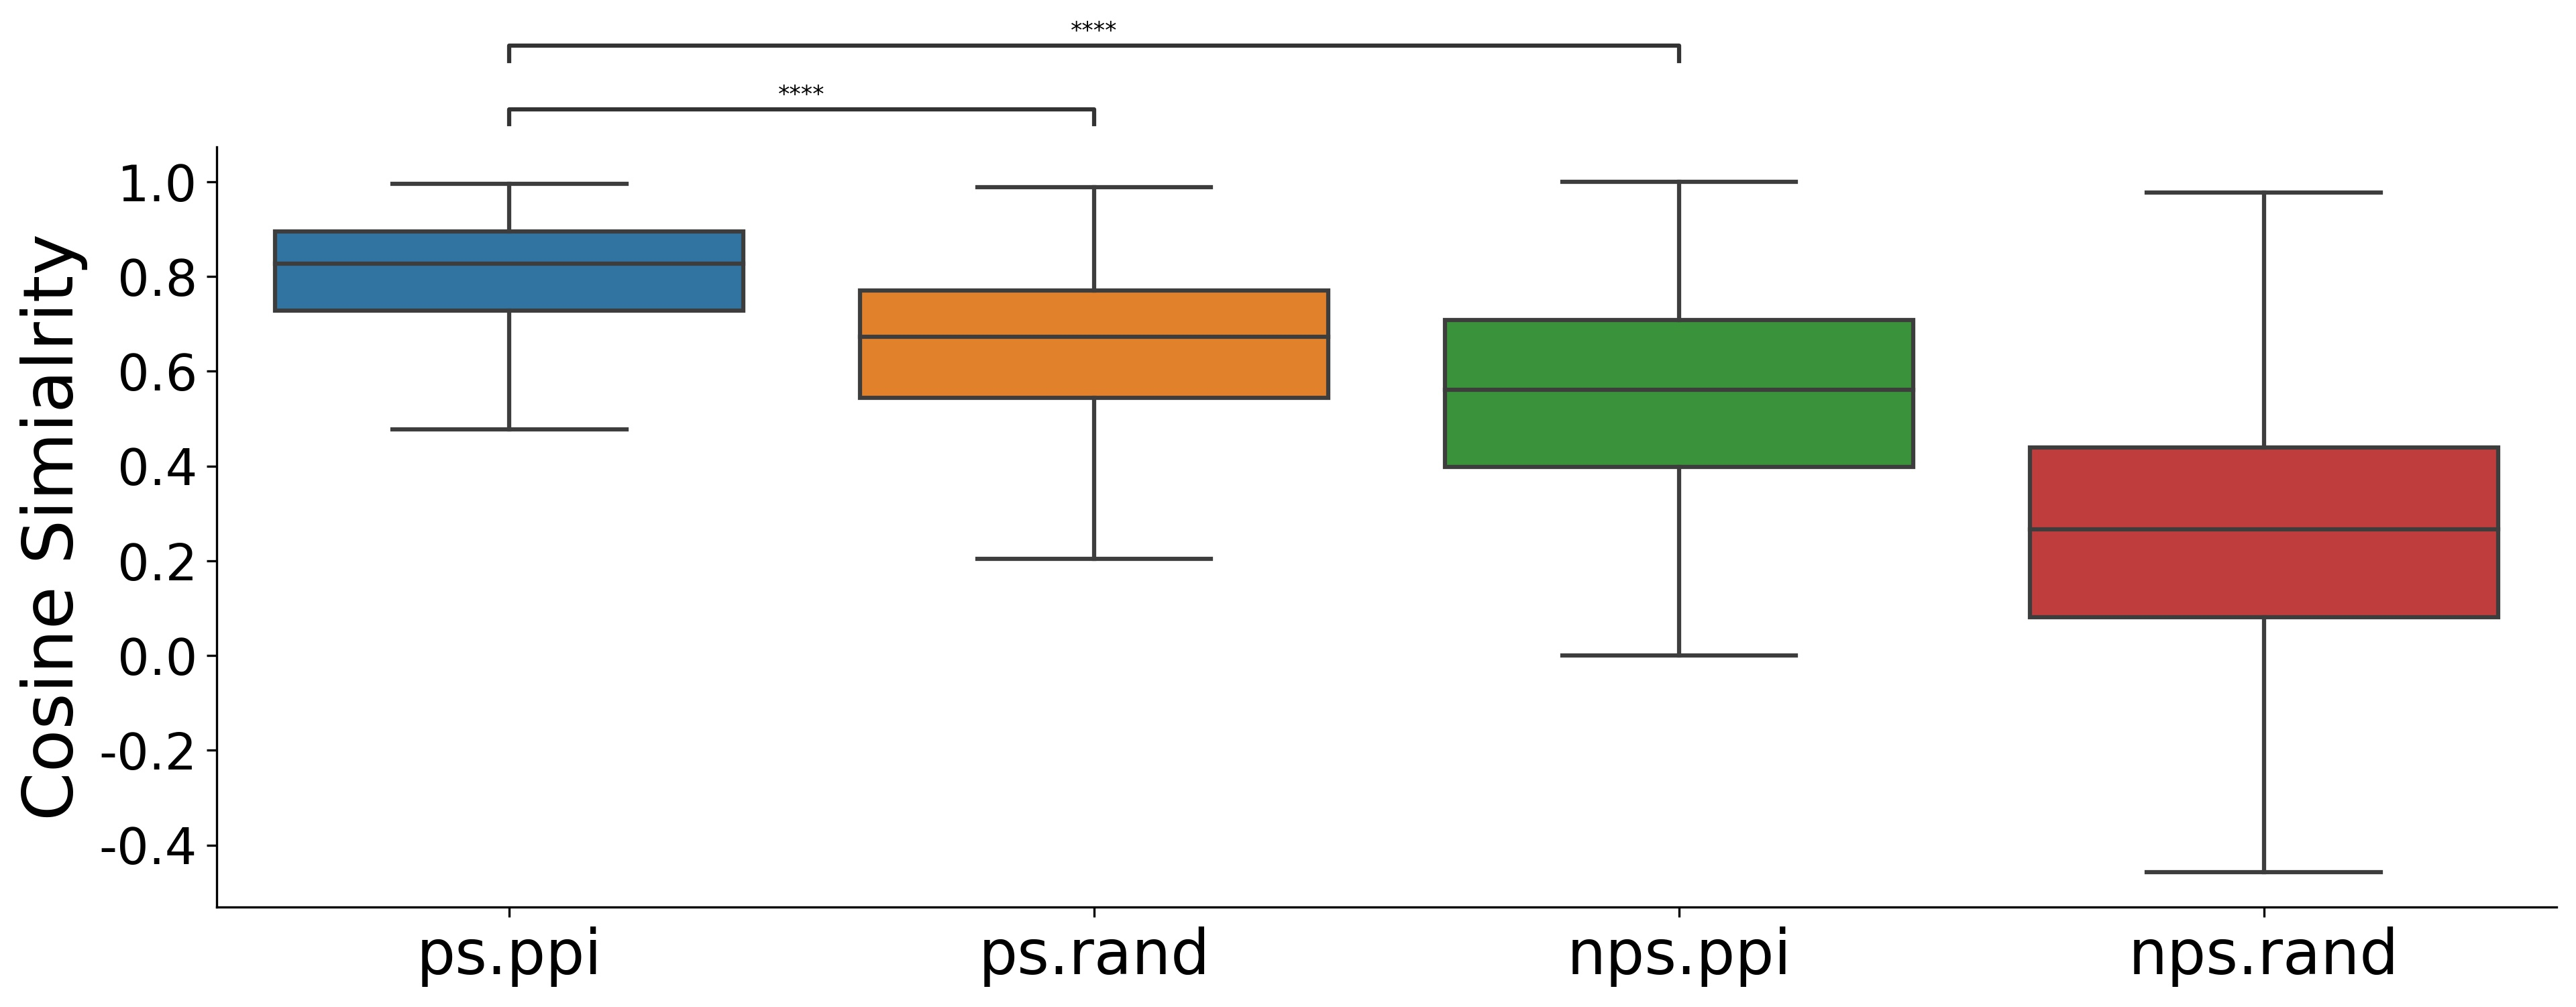

In [29]:
fig, ax = plt.subplots(
    figsize = (15, 5)
)
sns.boxplot(
    x = 'type',
    y = 'cosine.similarity',
    data = dat_plt,
    ax = ax,
    showfliers = False
)
ax.set_xlabel(None)
ax.set_ylabel('Cosine Simialrity', size=25)
ax.set_xticklabels(['ps.ppi', 'ps.rand', 'nps.ppi', 'nps.rand'], size=22)
ax.set_yticklabels([round(i, 2) for i in np.arange(-.6, 1.2, .2)], size=18)
ax.spines['top'].set_visible(None)
ax.spines['right'].set_visible(None)

from statannot import add_stat_annotation
add_stat_annotation(
    ax, x='type', y='cosine.similarity', data=dat_plt,
    box_pairs=[
        ('ps.ppi', 'ps.rand'),
        ('ps.ppi', 'nps.ppi')
    ],
    test='Mann-Whitney', 
    comparisons_correction=None,
    text_format='star', 
    loc='outside', 
    verbose=2, 
    fontsize='small'
)

# Draw ROC curve

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [31]:
dat_plt['type'].value_counts()

nps.ppi     238562
nps.rand    238562
ps.rand     237569
ps.ppi        2902
Name: type, dtype: int64

In [32]:
score = 'cosine.similarity'
df = dat_plt[dat_plt['type'].isin(['ps.ppi', 'ps.rand'])].reset_index(drop=True)
# df = dat_plt.copy()

probs, y_test = df[score].to_numpy(), df['type'].to_numpy()
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=0)
roc_auc = auc(fpr, tpr)

In [33]:
roc_auc

0.7745760534516435

Text(0.5, 1.0, 'Classification of\nPS-PPI and PS-Random')

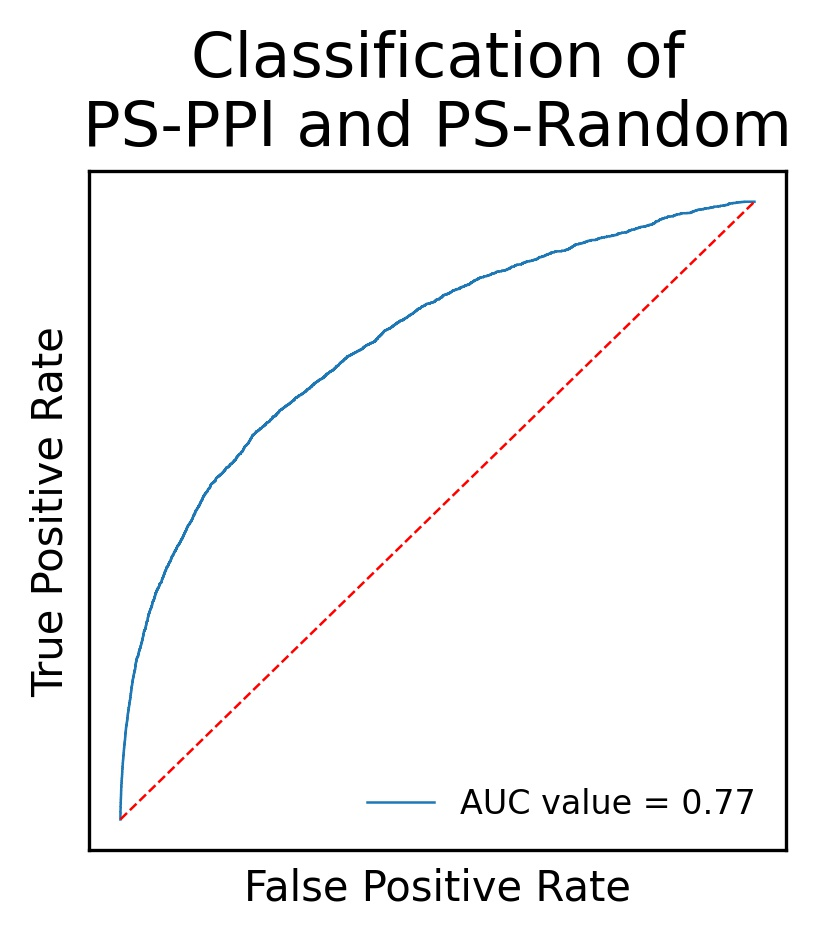

In [34]:
fig, ax = plt.subplots(figsize=(3, 3))

ALPHA = 1
LW = .6
ax.plot(
    fpr, tpr,
    lw = LW,
    alpha = ALPHA,
    label='AUC value = {:.2f}'.format(roc_auc)
)

ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.legend(loc="lower right", fontsize=8, frameon=False)
ax.set_xticks([])
ax.set_yticks([])
ax.plot([0, 1], [0, 1], 'r--', lw=LW)
ax.set_title('Classification of\nPS-PPI and PS-Random', size=15)

# Distinguishing between PS-PPI and PS-Random

In [49]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [100]:
n_model = 0

In [101]:
predict = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/gene_model.preds.pkl')

In [102]:
edges = pd.read_pickle(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_cosine/model_{n_model}.pkl')
edges = edges[['A', 'B', 'cosim']].copy()
edges[0] = np.sort(edges[['A', 'B']].values).sum(axis=1)
lt = predict[predict['type']=='literature']['entry'].tolist()
edges.loc[(edges['A'].isin(lt))&(edges['B'].isin(lt)), 'label'] = 1
edges['label'] = edges['label'].fillna(0).astype(int)

In [103]:
edges

,A,B,cosim,0,label
0,Q9H2S6,Q9NPE6,0.914216,Q9H2S6Q9NPE6,0
1,Q9H2S6,Q9BXK5,0.909164,Q9BXK5Q9H2S6,0
2,Q9H2S6,O60238,0.193015,O60238Q9H2S6,0
3,Q9H2S6,P20138,0.620930,P20138Q9H2S6,0
4,Q9H2S6,Q9UM44,0.010836,Q9H2S6Q9UM44,0
...,...,...,...,...,...
241459,Q15124,O95394,0.695139,O95394Q15124,0
241460,Q9HC38,P40261,0.631069,P40261Q9HC38,0
241461,Q9HC38,Q9NR45,0.766036,Q9HC38Q9NR45,0
241462,P39687,Q13219,0.535803,P39687Q13219,0


In [104]:
# positive samples (real PS-PPI)
pos_df = edges[edges['label']==1][['A', 'B', 'label', 'cosim', 0]].copy()

In [105]:
phasep_df = pd.read_pickle('./data/Label/human.condensate-formation.proteins-v1.pkl')
lt = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'])
dp = set(phasep_df[phasep_df['source']=='deepphase']['uniprot_entry'])
dp = dp - lt
pr = set(phasep_df[phasep_df['source']=='phasepred']['uniprot_entry'])
pr = pr - dp - lt

from itertools import combinations
lt_ppin = set(predict['entry'].tolist()) & lt
ps_comb = pd.DataFrame([i for i in combinations(lt_ppin, 2)])
ps_comb.columns = ['A', 'B']
ps_comb[0] = np.sort(ps_comb[['A', 'B']].values).sum(axis=1)

In [106]:
pairwise_cosim = pd.read_pickle(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/pairwise_cosine/model_{n_model}.pkl')

In [107]:
# negative samples (random interactions between PS proteins)
neg_df = ps_comb[~ps_comb[0].isin(pos_df[0])].copy()

# random selection from negative samples (pos: neg = 1: 3)
neg_df = neg_df.sample(n=3 * len(pos_df), random_state=1234)

neg_df['cosim'] = [pairwise_cosim[i['A']][i['B']] for _, i in tqdm(neg_df.iterrows())]
neg_df['label'] = 0

8706it [00:00, 15996.59it/s]


In [108]:
samples_df = pd.concat([pos_df, neg_df]).reset_index(drop=True)

In [109]:
samples_df.groupby('label')['cosim'].median()

label
0    0.671177
1    0.827244
Name: cosim, dtype: float32

In [110]:
tmp = samples_df[['B', 'A', 'cosim', 0, 'label']].copy()
tmp.columns = ['A', 'B', 'cosim', 0, 'label']

samples_rev = pd.concat([samples_df, tmp]).reset_index(drop=True)

In [111]:
samples_rev['label'].value_counts()

0    17412
1     5804
Name: label, dtype: int64

In [112]:
# 模型的读取
import os
import torch
SAVE_ROOT = './saves/INTEGRATE_unweight_ProSE80d_mcc/'
N = len(os.listdir(os.path.join(SAVE_ROOT, f'models/')))
models = {idx: torch.load(os.path.join(SAVE_ROOT, f'models/model_{idx}.pt')) for idx in range(N)}
genes = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/genes.pkl')

In [113]:
featuremap_df = pd.DataFrame(np.array(models[n_model].featuremap1.cpu()))
featuremap_df.index = genes

In [114]:
def feature_concat(row, feature):
    a, b = row['A'], row['B']
    array_a, array_b = feature.loc[a, :].to_numpy(), feature.loc[b, :].to_numpy()
    array = np.concatenate([array_a, array_b])
    return pd.DataFrame(array).T

In [115]:
from multiprocessing.pool import Pool
pool = Pool(processes=8)
para = [(e, featuremap_df) for _, e in tqdm(samples_rev.iterrows())]
hh = pool.starmap(feature_concat, para)
pool.close()
pool.join()

23216it [00:00, 24347.53it/s]


In [116]:
featurecat_df = pd.concat(hh, axis=0).reset_index(drop=True)
featurecat_df.columns = [f'x{i}' for i in range(featurecat_df.shape[1])]
samples_featurecat = pd.concat([samples_rev, featurecat_df], axis=1)

In [117]:
dat = dict()
dat['data'] = samples_featurecat[[f'x{i}' for i in range(featurecat_df.shape[1])]].to_numpy()
dat['target'] = samples_featurecat['label'].to_numpy()

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from xgboost import XGBClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [119]:
X_train, X_test, y_train, y_test = train_test_split(
    dat['data'], 
    dat['target'], 
    test_size=.2,
    random_state=1234
)
# create model instance
bst = XGBClassifier(
    # n_estimators=2, 
    # max_depth=2, 
    # learning_rate=1, 
    objective='binary:logistic'
)

In [120]:
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict_proba(X_test)

In [121]:
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)
fpr, tpr, _ = roc_curve(y_onehot_test[:, ], preds[:, 1], pos_label=1)
auc(fpr, tpr)

0.9072332966851372

In [122]:
samples_rev['prob'] = bst.predict_proba(dat['data'])[:, 1]

In [123]:
diff = samples_rev[[0, 'label', 'prob']].copy()
c2min_dict = samples_rev.groupby(0)['prob'].min().to_dict()
diff['min'] = diff[0].map(c2min_dict)
diff['diff.abs'] = abs(diff['prob'] - diff['min'])
diff = diff.sort_values(by=[0, 'diff.abs'], ascending=[True, True]).drop_duplicates(subset=[0], keep='last').reset_index(drop=True)

In [124]:
diff.groupby('label')['diff.abs'].median()

label
0    0.013536
1    0.052796
Name: diff.abs, dtype: float64

In [125]:
diff.groupby('label')['diff.abs'].mean()

label
0    0.041009
1    0.119778
Name: diff.abs, dtype: float64

In [126]:
c2mean_dict = samples_rev.groupby(0)['prob'].mean().to_dict()
samples_df['mean.prob'] = samples_df[0].map(c2mean_dict)

In [127]:
samples_df

,A,B,label,cosim,0,mean.prob
0,P50222,P06241,1,0.238954,P06241P50222,0.834571
1,P50222,Q9UPU9,1,0.430368,P50222Q9UPU9,0.754809
2,P50222,Q969G3,1,0.382141,P50222Q969G3,0.745082
3,P50222,Q9NQT4,1,0.503582,P50222Q9NQT4,0.895610
4,P50222,P02792,1,0.324480,P02792P50222,0.724368
...,...,...,...,...,...,...
11603,Q09161,Q14103,0,0.821055,Q09161Q14103,0.236861
11604,Q12888,P25685,0,0.755139,P25685Q12888,0.017201
11605,Q01844,P23396,0,0.852772,P23396Q01844,0.335678
11606,Q9BRP8,O96028,0,0.879106,O96028Q9BRP8,0.123169


In [128]:
samples_df.groupby('label')['mean.prob'].median()

label
0    0.023965
1    0.865162
Name: mean.prob, dtype: float64

In [129]:
# real non-PS PPI
nonPS_ppi = edges[edges['label']==0].reset_index(drop=True)
tmp = nonPS_ppi[['B', 'A', 'cosim', 0, 'label']].copy()
tmp.columns = ['A', 'B', 'cosim', 0, 'label']

nonPS_ppi_rev = pd.concat([nonPS_ppi, tmp]).reset_index(drop=True)

In [130]:
# random interactions between non-PS PPI
from itertools import combinations
from random import sample, seed
seed(1234)
notps_ppin = sample(set(predict['entry'].tolist()) - lt_ppin, len(lt_ppin) * 3) # random selection of non-PS proteins

notps_comb = pd.DataFrame([i for i in combinations(notps_ppin, 2)])
notps_comb.columns = ['A', 'B']
notps_comb[0] = np.sort(notps_comb[['A', 'B']].values).sum(axis=1)

# random selection from negative samples (pos: neg = 1: 3)
neg_df = neg_df.sample(n=3 * len(pos_df), random_state=1234)

neg_df['cosim'] = [pairwise_cosim[i['A']][i['B']] for _, i in tqdm(neg_df.iterrows())]
neg_df['label'] = 0

8706it [00:00, 19315.07it/s]


In [131]:
from multiprocessing.pool import Pool
pool = Pool(processes=8)
para = [(e, featuremap_df) for _, e in tqdm(nonPS_ppi_rev.iterrows())]
hh = pool.starmap(feature_concat, para)
pool.close()
pool.join()

477124it [00:22, 21210.29it/s]


In [132]:
featurecat_df = pd.concat(hh, axis=0).reset_index(drop=True)
featurecat_df.columns = [f'x{i}' for i in range(featurecat_df.shape[1])]
nonPS_ppi_featurecat = pd.concat([nonPS_ppi_rev, featurecat_df], axis=1)

In [133]:
dat2 = dict()
dat2['data'] = nonPS_ppi_featurecat[[f'x{i}' for i in range(featurecat_df.shape[1])]].to_numpy()
# dat2['target'] = nonPS_ppi_featurecat['label'].to_numpy()

In [134]:
nonPS_ppi_rev['prob'] = bst.predict_proba(dat2['data'])[:, 1]

In [135]:
nonPS_ppi['mean.prob'] = nonPS_ppi[0].map(nonPS_ppi_rev.groupby(0)['prob'].mean().to_dict())

In [136]:
nonPS_ppi['label'] = nonPS_ppi['label'].replace({0: 2})
ppigrp_df = pd.concat([samples_df, nonPS_ppi], axis=0).reset_index(drop=True)
ppigrp_df['label'] = ppigrp_df['label'].replace({
    1: 'ps-ppi',
    0: 'ps-rand',
    2: 'nonps-ppi'
})

In [137]:
ppigrp_df.groupby('label').median()

,cosim,mean.prob
label,,
nonps-ppi,0.560506,0.024307
ps-ppi,0.827244,0.865162
ps-rand,0.671177,0.023965


In [138]:
val1, val2 = ppigrp_df[ppigrp_df['label']=='ps-rand']['mean.prob'].values, ppigrp_df[ppigrp_df['label']=='nonps-ppi']['mean.prob'].values
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val1, val2, alternative='greater')
print(np.median(val1), np.median(val2), p)

0.023964853957295418 0.024307437241077423 0.99999999998874


In [139]:
c2mean_dict = ppigrp_df.set_index(0).to_dict()['mean.prob']
edges['prob'] = edges[0].map(c2mean_dict)

In [140]:
edges['weight.1'] = edges['cosim'] * (1 + edges['prob'])
edges.loc[edges['weight.1'] < 0, 'weight.1'] = 0
edges.loc[edges['weight.1'] > 1, 'weight.1'] = 1

In [55]:
# edges[['A', 'B', 'weight.1']].to_csv('./saves/INTEGRATE_unweight_ProSE80d_mcc/weighted_edge_list_0.xgboost.txt', sep=' ', header=None, index=None)

In [141]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [142]:
phasep = phasep_df['uniprot_entry'].drop_duplicates().tolist()
ps_plus = set(edges.loc[(edges['A'].isin(phasep))&(edges['B'].isin(phasep))][0].tolist())
ps_mins = set(edges.loc[(edges['A'].isin(phasep))|(edges['B'].isin(phasep))][0].tolist())
ps_mins = ps_mins - ps_plus
nc = set(edges[0].tolist()) - ps_mins - ps_plus

edges.loc[edges[0].isin(ps_plus), 'type'] = 'ps.plus'
edges.loc[edges[0].isin(ps_mins), 'type'] = 'ps.mins'
edges.loc[edges[0].isin(nc), 'type'] = 'nc'

In [143]:
ppigrp_df['label'].value_counts()

nonps-ppi    238562
ps-rand        8706
ps-ppi         2902
Name: label, dtype: int64

In [144]:
phasepred_df = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')
entry2pdps_dict = phasepred_df.set_index('entry').to_dict()['PdPS-10fea']
entry2saps_dict = phasepred_df.set_index('entry').to_dict()['SaPS-10fea']

In [145]:
ppigrp_df['A.PdPS'] = ppigrp_df['A'].map(entry2pdps_dict)
ppigrp_df['B.PdPS'] = ppigrp_df['B'].map(entry2pdps_dict)
ppigrp_df['A.SaPS'] = ppigrp_df['A'].map(entry2saps_dict)
ppigrp_df['B.SaPS'] = ppigrp_df['B'].map(entry2saps_dict)
ppigrp_df['PdPS'] = (ppigrp_df['A.PdPS'] + ppigrp_df['B.PdPS']) / 2
ppigrp_df['SaPS'] = (ppigrp_df['A.SaPS'] + ppigrp_df['B.SaPS']) / 2

In [146]:
ppigrp_df.groupby('label').mean()

,cosim,mean.prob,A.PdPS,B.PdPS,A.SaPS,B.SaPS,PdPS,SaPS
label,,,,,,,,
nonps-ppi,0.543549,0.115405,0.409574,0.386866,0.320924,0.302600,0.398220,0.311762
ps-ppi,0.794046,0.801342,0.751226,0.720236,0.639845,0.616482,0.735731,0.628163
ps-rand,0.634867,0.062622,0.639420,0.631364,0.535579,0.539533,0.635392,0.537556


In [ ]:
"""
score = 'PdPS'
df = ppigrp_df[ppigrp_df['label'].isin(['ps-ppi', 'ps-rand'])].reset_index(drop=True)

probs, y_test = df[score].to_numpy(), df['label'].to_numpy()
label_binarizer = LabelBinarizer().fit(y_test)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=0)
roc_auc = auc(fpr, tpr)
print(roc_auc)
"""

In [176]:
from collections import defaultdict
score_dict = defaultdict()
score_cols = ['cosim', 'PdPS', 'SaPS', 'mean.prob']

df = ppigrp_df[ppigrp_df['label'].isin(['ps-ppi', 'ps-rand'])].reset_index(drop=True)

for s in score_cols:
    probs, y_test = df[s].to_numpy(), df['label'].to_numpy()
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=0)
    roc_auc = auc(fpr, tpr)
    score_dict[s] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

Text(0.5, 1.0, 'Classification of\nPS-PPI and PS-Random')

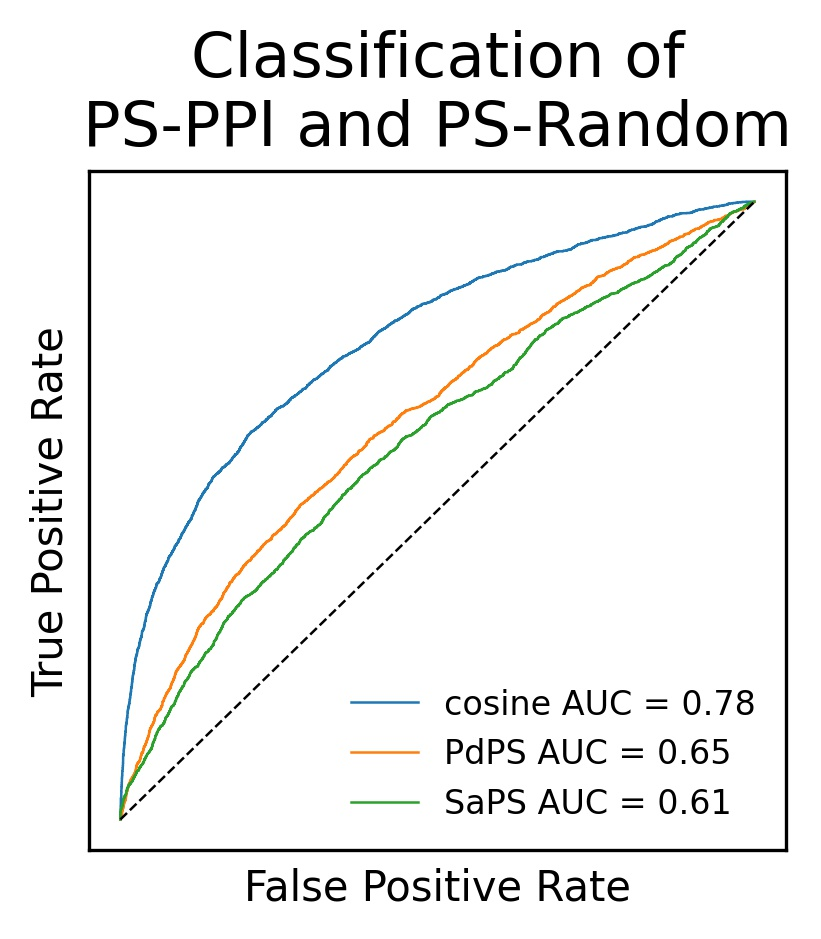

In [177]:
fig, ax = plt.subplots(figsize=(3, 3))

ALPHA = 1
LW = .6

for key, val in score_dict.items():
    fpr, tpr, auc_val = val['fpr'], val['tpr'], val['auc']
    if key == 'mean.prob':
        # key = 'xgboost'
        continue
    elif key == 'cosim':
        key = 'cosine'
    ax.plot(
        fpr, tpr,
        lw = LW,
        alpha = ALPHA,
        label='{} AUC = {:.2f}'.format(key, auc_val)
    )



ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.legend(loc="lower right", fontsize=8, frameon=False)
ax.set_xticks([])
ax.set_yticks([])
ax.plot([0, 1], [0, 1], 'k--', lw=LW)
ax.set_title('Classification of\nPS-PPI and PS-Random', size=15)

Text(0.5, 1.0, 'Classification of\nPS-PPI and nonPS-PPI')

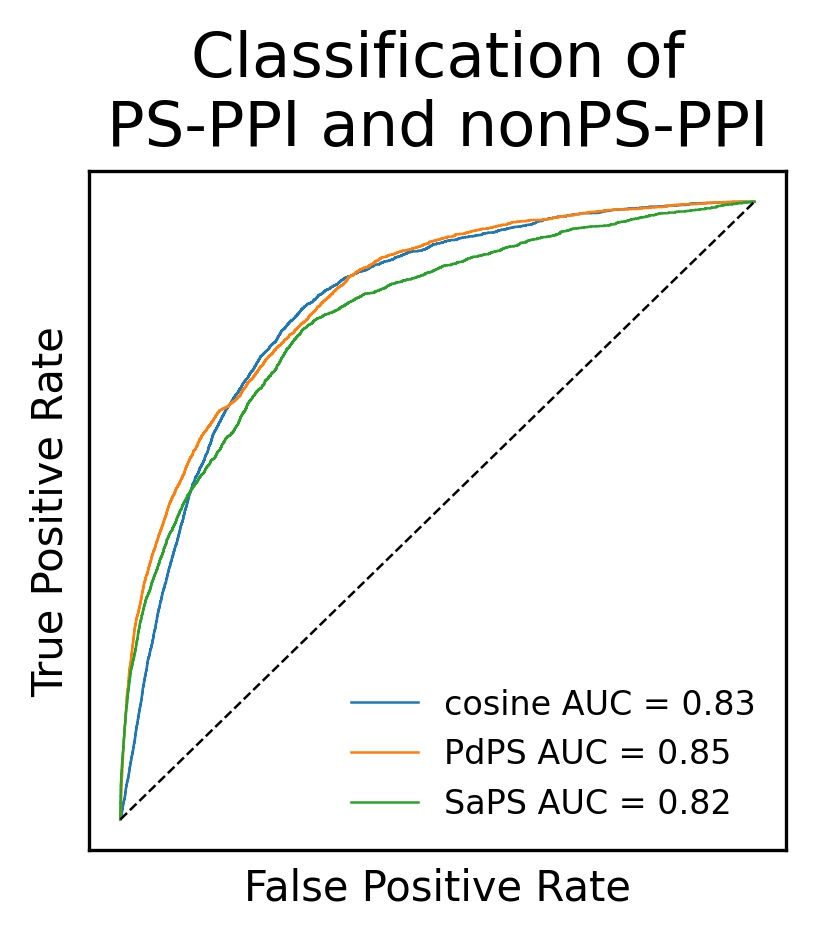

In [179]:
from collections import defaultdict
score_dict = defaultdict()
score_cols = ['cosim', 'PdPS', 'SaPS', 'mean.prob']

df = ppigrp_df[ppigrp_df['label'].isin(['ps-ppi', 'nonps-ppi'])].reset_index(drop=True)

for s in score_cols:
    probs, y_test = df[s].to_numpy(), df['label'].to_numpy()
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)

    fpr, tpr, _ = roc_curve(y_onehot_test[:, ], probs[:, ], pos_label=1)
    roc_auc = auc(fpr, tpr)
    score_dict[s] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }

fig, ax = plt.subplots(figsize=(3, 3))

ALPHA = 1
LW = .6

for key, val in score_dict.items():
    fpr, tpr, auc_val = val['fpr'], val['tpr'], val['auc']
    if key == 'mean.prob':
        # key = 'xgboost'
        continue
    elif key == 'cosim':
        key = 'cosine'
    ax.plot(
        fpr, tpr,
        lw = LW,
        alpha = ALPHA,
        label='{} AUC = {:.2f}'.format(key, auc_val)
    )



ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.legend(loc="lower right", fontsize=8, frameon=False)
ax.set_xticks([])
ax.set_yticks([])
ax.plot([0, 1], [0, 1], 'k--', lw=LW)
ax.set_title('Classification of\nPS-PPI and nonPS-PPI', size=15)

# 2023年4月12日19:12:44

整合ppin和single-cell coexpr，产生新的融合网络时，合并网络时应该留下ps-ppi的edges（两侧都是相变蛋白更倾向于产生新的edges）. 

不同的single-cell coexpr data得到不同single-cell coexpr network. 可以试试single-cell expr作为node feature.

有些condensate是细胞系特异的，比如突触后小体。脑组织（突触后小体）、造血（PML body）GTEx → bulk/single-cell coexpr network. MloDisDB

**用组织特异性的网络是否能找到specific condensate.**

方案1. 用unweighted ppin和single-cell coexpr network作为bionic的输入，整合之后作为PhaSepGAT的input重新输出

方案2. 直接用cosine-weighted ppin和single-cell coexpr network作为bionic的输入，直接得到一个新的整合网络

**方案3**. 所有蛋白pair之间的权重（cosine similarity，Top5%、10%、根据AUC选择threshold）、unweighted ppin和single-cell coexpr network. （为什么要加上所有蛋白pair之间的权重？是为了找到那些尚没有ppi，但是高cosine的蛋白pair）

Ablation study: 去掉哪个network，condensate找不到了

## ① 所有蛋白pair之间的权重网络（cosine similarity-top5%）

In [438]:
pairwise_cosim = pd.read_pickle(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/pairwise_cosine/model_{n_model}.pkl')

In [455]:
pairwise_cosim_ndarray = pairwise_cosim.to_numpy()
pairwise_cosim_idx = np.tril_indices_from(pairwise_cosim_ndarray, -1)
idx0, idx1 = pairwise_cosim_idx[0].tolist(), pairwise_cosim_idx[1].tolist()

In [457]:
pairwise_cosim_ltri = pairwise_cosim_ndarray[idx0, idx1]

In [460]:
pairwise_cosim_ltri

array([ 0.02089855,  0.25323412,  0.21826258, ...,  0.22449522,
        0.23624553, -0.23242976], dtype=float32)

In [500]:
pairwise_cosim_ltri_df = pd.DataFrame({
    'idx0': idx0,
    'idx1': idx1,
    'cosine': pairwise_cosim_ltri
})

In [511]:
index2entry_dict2 = dict(zip(np.arange(len(pairwise_cosim.columns)), pairwise_cosim.columns))

In [512]:
pairwise_cosim_ltri_df['A'] = pairwise_cosim_ltri_df['idx0'].map(index2entry_dict2)
pairwise_cosim_ltri_df['B'] = pairwise_cosim_ltri_df['idx1'].map(index2entry_dict2)

In [517]:
pairwise_cosim_high_df = pairwise_cosim_ltri_df[pairwise_cosim_ltri_df['cosine'] >= edges['cosim'].quantile(.95)].reset_index(drop=True)

In [518]:
pairwise_cosim_high_df

,idx0,idx1,cosine,A,B
0,32,27,0.893243,A0PJY2,A0PJW8
1,46,27,0.876185,A1E959,A0PJW8
2,48,12,0.921363,A1KXE4,A0AV96
3,96,27,0.914743,A2VCK2,A0PJW8
4,96,32,0.883817,A2VCK2,A0PJY2
...,...,...,...,...,...
184868,15936,14259,0.892045,Q9Y6Y8,Q9NX70
184869,15936,14433,0.896601,Q9Y6Y8,Q9NZM3
184870,15936,15132,0.892139,Q9Y6Y8,Q9ULK4
184871,15936,15287,0.872704,Q9Y6Y8,Q9UPQ9


In [520]:
edges_top5 = pairwise_cosim_high_df[['A', 'B', 'cosine']].copy()
edges_top5.columns = ['A', 'B', 'weight']

In [521]:
edges_top5.head()

,A,B,weight
0,A0PJY2,A0PJW8,0.893243
1,A1E959,A0PJW8,0.876185
2,A1KXE4,A0AV96,0.921363
3,A2VCK2,A0PJW8,0.914743
4,A2VCK2,A0PJY2,0.883817


## ② Unweighted PPIN

In [539]:
edges_uwig = edges[['A', 'B']].copy()
edges_uwig['weight'] = 1

In [812]:
edges_wig = edges[['A', 'B', 'cosim']].copy()
edges_wig.columns = ['A', 'B', 'weight']

In [813]:
edges_wig.head()

,A,B,weight
0,Q9H2S6,Q9NPE6,0.862351
1,Q9H2S6,Q9BXK5,0.624710
2,Q9H2S6,O60238,0.068534
3,Q9H2S6,P20138,0.283145
4,Q9H2S6,Q9UM44,0.241230


## ③ Single-cell expression network

In [525]:
entrymap_df = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_idmapping.pkl')
symbol2entry_dict = entrymap_df[entrymap_df['ID_types']=='GeneSymbol'].set_index('IDs').to_dict()['uniprot_entry']

In [526]:
scnet_df = pd.read_table('./data/PPIN/Immune-Specific_Network_B.txt')

In [527]:
scnet_df['A'] = scnet_df['geneA'].map(symbol2entry_dict)
scnet_df['B'] = scnet_df['geneB'].map(symbol2entry_dict)
scnet_df = scnet_df[(scnet_df['A'].notna())&(scnet_df['B'].notna())][['A', 'B', 'weight']]

In [528]:
scnet_df['weight'] = scnet_df['weight'] / 1e3
scnet_df['weight'] = scnet_df['weight'].apply(lambda x: round(x, 4))

In [529]:
from itertools import chain

def chainer(s, sep):
    return list(chain.from_iterable(s.str.split(sep)))

def split_items(dataframe, col_name, sep):
    lens = dataframe[col_name].str.split(sep).map(len)
    cols = dataframe.columns
    dict1 = {c: np.repeat(dataframe[c], lens) for c in cols}
    dict1[col_name] = chainer(dataframe[col_name], sep)
    return pd.DataFrame(dict1)

In [530]:
scnet_df = split_items(split_items(scnet_df, 'A', ','), 'B', ',').reset_index(drop=True)

In [531]:
scnet_df.head()

,A,B,weight
0,P01023,P04217,0.0719
1,P03950,P04217,0.0133
2,P20073,P04217,0.1286
3,P07307,P04217,0.0176
4,P01024,P04217,0.0099


In [836]:
scnet_df1 = scnet_df[(scnet_df['A'].isin(pairwise_cosim.columns))&(scnet_df['B'].isin(pairwise_cosim.columns))].reset_index(drop=True)

In [837]:
scnet_weights = list()
for _, i in tqdm(scnet_df1.iterrows()):
    a, b = i['A'], i['B']
    scnet_weights.append(pairwise_cosim[a][b])

676225it [00:37, 18173.48it/s]


In [838]:
scnet_df1['cosine'] = scnet_weights

In [846]:
scnet_thre_df = scnet_df1[scnet_df1['cosine'] >= scnet_df1['cosine'].quantile(.95)].reset_index(drop=True)

In [848]:
scnet_thre_df

,A,B,weight,cosine
0,P57740,Q9NRG9,0.0063,0.832275
1,Q8WUM0,Q9NRG9,0.0062,0.846972
2,P49790,Q9NRG9,0.0060,0.830401
3,Q12769,Q9NRG9,0.0045,0.864870
4,Q5SRE5,Q9NRG9,0.0063,0.827017
...,...,...,...,...
33807,Q9Y462,O15015,0.0238,0.834246
33808,A6NHJ4,Q5HYK9,0.1774,0.844331
33809,P17097,Q86XU0,0.1047,0.822186
33810,Q2TB10,Q6IQ21,0.0967,0.851011


In [738]:
# prots_in_scnet = set(pd.concat([scnet_df['A'], scnet_df['B']]).drop_duplicates().tolist())
# prots_in_integ = set(pd.concat([edges['A'], edges['B']]).drop_duplicates().tolist())
# print(len(prots_in_integ & prots_in_scnet) / len(prots_in_scnet))

0.9199362965107861


## Save networks

In [534]:
import os
SAVE_ROOT_BIONIC = '/home/lyz/co-phase-separation/software/BIONIC-0.1.0/bionic/inputs/'

In [810]:
print(edges_top5.shape[0], edges_uwig.shape[0], scnet_thre_df.shape[0])

184873 241464 46853


In [542]:
# edges_top5.to_csv(os.path.join(SAVE_ROOT_BIONIC, 'cosine_similarity_top5.txt'), index=None, header=None, sep=' ')
# edges_uwig.to_csv(os.path.join(SAVE_ROOT_BIONIC, 'unweighted_integrated_ppin.txt'), index=None, header=None, sep=' ')
# scnet_thre_df.to_csv(os.path.join(SAVE_ROOT_BIONIC, 'single-cell_exprnet_B.txt'), index=None, header=None, sep=' ')

In [849]:
scnet_thre_df[['A', 'B', 'weight']].to_csv(os.path.join(SAVE_ROOT_BIONIC, 'single-cell_exprnet_B_cosine.txt'), index=None, header=None, sep=' ')

In [814]:
# edges_wig.to_csv(os.path.join(SAVE_ROOT_BIONIC, 'weighted_integrated_ppin.txt'), index=None, header=None, sep=' ')

## Processing BIONIC outputs

In [8]:
embeds = pd.read_table('/home/lyz/co-phase-separation/software/BIONIC-0.1.0/bionic/outputs/230414_cosine_unweighted_B_features.tsv').set_index('Unnamed: 0')

In [9]:
import networkx as nx
def get_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    g = nx.Graph()
    g.add_edges_from(edges)
    return g

def process_BIONIC_outputs(embeds, cutoff=.5):
    array1 = embeds.to_numpy()
    array2 = array1.T
    array_dot = np.dot(array1, array2)
    
    adjmat = np.array(array_dot >= cutoff, dtype=np.int)
    g = get_graph(adjmat)
    edge_df = pd.DataFrame(g.edges)
    
    index2entry_dict = dict(zip(np.arange(len(embeds.index)), embeds.index))
    edge_df['A'] = edge_df[0].map(index2entry_dict)
    edge_df['B'] = edge_df[1].map(index2entry_dict)
    
    weights_df = pd.DataFrame(array_dot)
    weights_df.columns = embeds.index.tolist()
    weights_df.index = embeds.index.tolist()
    
    from tqdm import tqdm
    edge_weights = list()
    for _, i in tqdm(edge_df.iterrows()):
        a, b = i['A'], i['B']
        w = weights_df[a][b]
        # print(a, b, w)
        edge_weights.append(w)
    edge_df['w'] = edge_weights
    return edge_df

In [10]:
edge_df = process_BIONIC_outputs(embeds)

20368it [00:01, 17373.81it/s]


In [11]:
edge_df = edge_df[edge_df['A']!=edge_df['B']].reset_index(drop=True)

In [12]:
edge_df

,0,1,A,B,w
0,1,251,A0A087WUL8,A8MQ03,1.555268
1,1,543,A0A087WUL8,O14633,0.586584
2,1,602,A0A087WUL8,O14817,0.500826
3,1,968,A0A087WUL8,O43609,0.572182
4,1,1560,A0A087WUL8,O76011,0.550613
...,...,...,...,...,...
17109,15300,15830,Q9UN74,Q9Y5I2,0.541072
17110,15300,15831,Q9UN74,Q9Y5I3,0.508081
17111,15827,15830,Q9Y5H9,Q9Y5I2,0.518550
17112,15830,15831,Q9Y5I2,Q9Y5I3,0.523719


In [679]:
edge_df[['A', 'B', 'w']].to_csv('./scNet.B.230418.txt', sep=' ', index=None, header=None)

In [30]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [31]:
cl = pd.read_csv('./cl.scNet.B.csv')

In [32]:
cl

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members
0,1,22,0.7216,166.700,79.5800,0.5742,3.433560e-07,O15446 O00567 P02545 P09874 P22087 P27695 P384...
1,2,122,0.2040,1506.000,982.7000,0.5510,0.000000e+00,P06748 P26373 P36578 P39023 P40429 P46781 P509...
2,3,71,0.3172,788.300,41.7900,0.8109,0.000000e+00,A0A087WUL8 A8MQ03 O14633 O14817 O43609 P0C7H8 ...
3,4,76,0.6605,1883.000,501.7000,0.7423,0.000000e+00,P60228 O76094 P05387 P06748 P08865 P15880 P181...
4,5,85,0.2884,1030.000,48.7000,0.8248,0.000000e+00,Q8N144 O00559 O14983 O15173 O15400 O43752 O759...
...,...,...,...,...,...,...,...,...
205,206,16,0.3904,46.840,20.2600,0.4727,3.999630e-05,Q9NZB2 Q12926 Q96DU9 O15504 O60812 O75152 O957...
206,207,4,0.6380,3.828,0.5119,0.3102,1.325940e-02,O43747 P56377 Q9Y6Q5 Q96PC3
207,208,9,0.4090,14.720,16.3900,0.2998,2.392430e-02,P0DTE7 P0DTE8 P0DUB6 P01037 P47874 Q3KR16 Q8NG...
208,209,7,0.5065,10.640,2.6140,0.3903,6.515630e-03,O75064 P0DP23 P0DP25 P0DP24 Q9H095 Q9NRF2 Q92585


In [33]:
phasep_df = pd.read_pickle('./data/Label/human.condensate-formation.proteins-v1.pkl')
lt = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'])
dp = set(phasep_df[phasep_df['source']=='deepphase']['uniprot_entry'])
dp = dp - lt
pr = set(phasep_df[phasep_df['source']=='phasepred']['uniprot_entry'])
pr = pr - dp - lt

In [34]:
edges = pd.read_pickle('./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_cosine/model_0.pkl')

edges = edges[['A', 'B', 'cosim']].copy()

lt = phasep_df[phasep_df['source']=='literature']['uniprot_entry'].tolist()
edges.loc[(edges['A'].isin(lt))&(edges['B'].isin(lt)), 'type'] = 1
edges['type'] = edges['type'].fillna(0).astype(int)

In [35]:
pos = set(phasep_df[phasep_df['source']=='literature']['uniprot_entry'].tolist())
pos = pos & set(embeds.index.tolist())

NameError: name 'embeds' is not defined

In [36]:
def phasep_enrich(x):
    mem = set(x.split(' '))
    a = pos & mem
    b = mem - pos
    c = pos - mem
    d = set(embeds.index.tolist()) - pos - mem
    from scipy.stats import fisher_exact
    _, p = fisher_exact([[len(a), len(b)], [len(c), len(d)]], alternative='greater')
    return p

In [17]:
cl['enr.pval'] = cl['Members'].apply(lambda x: phasep_enrich(x))

In [18]:
pspred = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')
entry2saps_dict = pspred.set_index('entry').to_dict()['SaPS-10fea']
entry2pdps_dict = pspred.set_index('entry').to_dict()['PdPS-10fea']

cl['avg.PdPS-10fea'] = cl['Members'].apply(lambda x: np.mean([entry2pdps_dict[i] for i in x.split(' ')]))

In [76]:
cl[(cl['enr.pval'] < .01)].sort_values(by=['avg.PdPS-10fea', 'P-value'], ascending=[False, True])

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members,enr.pval,avg.PdPS-10fea
138,139,4,0.8638,5.183,0.5198,0.37820,1.325940e-02,P09651 P35637 P51991 Q92804,3.577011e-06,0.927047
96,97,4,0.7802,4.681,35.5100,0.09713,4.422750e-01,Q13247 Q08170 P78362 Q07955,3.189510e-04,0.873988
41,42,17,0.3936,53.520,27.9800,0.46340,3.874940e-05,P05787 O14777 O95613 P05783 P08727 Q15154 Q49A...,5.403594e-03,0.803460
0,1,22,0.7216,166.700,79.5800,0.57420,3.433560e-07,O15446 O00567 P02545 P09874 P22087 P27695 P384...,1.607379e-07,0.744263
172,173,141,0.2986,2948.000,173.6000,0.86610,0.000000e+00,P60228 O76094 P05387 P06748 P08865 P15880 P181...,2.093413e-12,0.689439
1,2,122,0.2040,1506.000,982.7000,0.55100,0.000000e+00,P06748 P26373 P36578 P39023 P40429 P46781 P509...,8.830466e-17,0.685858
68,69,10,0.4801,21.610,78.9100,0.17930,9.190140e-01,Q6ZN17 Q00577 Q4G0J3 Q8TBF4 Q9H9Z2 Q9UL40 Q9Y2...,7.857764e-03,0.634935
140,141,7,0.5603,11.770,0.5317,0.44740,7.068820e-04,P11309 Q8TAP8 Q96F86 Q12796 Q6P2E9 Q8IU60 Q9NPI6,1.126370e-04,0.597415
103,104,5,0.6193,6.193,3.2650,0.31830,1.722680e-02,P11309 Q8TAP8 Q96F86 Q8IU60 Q8IZD4,7.714800e-04,0.595683
44,45,15,0.3678,38.620,2.0460,0.54650,7.902250e-07,O75694 P18754 P35658 P49790 P49792 P52948 P577...,2.130613e-09,0.432133


In [37]:
entrymap_df = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_idmapping.pkl')

from itertools import chain

def chainer(s, sep):
    return list(chain.from_iterable(s.str.split(sep)))

def split_items(dataframe, col_name, sep):
    lens = dataframe[col_name].str.split(sep).map(len)
    cols = dataframe.columns
    dict1 = {c: np.repeat(dataframe[c], lens) for c in cols}
    dict1[col_name] = chainer(dataframe[col_name], sep)
    return pd.DataFrame(dict1)

In [38]:
entry2symbol_df = entrymap_df[entrymap_df['ID_types']=='GeneSymbol'].copy()
entry2symbol_df = split_items(entry2symbol_df, 'uniprot_entry', sep=',')
entry2symbol_dict = entry2symbol_df.set_index('uniprot_entry').to_dict()['IDs']

In [39]:
phasepred_df = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_PhaSePred_SaPS_PdPS.pkl')
entry2pdps_dict = phasepred_df.set_index('entry').to_dict()['PdPS-10fea']
entry2saps_dict = phasepred_df.set_index('entry').to_dict()['SaPS-10fea']

def func1(x):
    m = x.split(' ')
    e = edges[(edges['A'].isin(m))&(edges['B'].isin(m))].reset_index(drop=True)
    n = pd.DataFrame(m)
    n[1] = n[0].map(entry2pdps_dict)
    n[2] = n[0].map(entry2symbol_dict)
    n.columns = ['name', 'PdPS-10fea', 'gene.name']
    return e, n

In [41]:
# x = cl[(cl['enr.pval'] < .01)].sort_values(by=['avg.PdPS-10fea', 'P-value'], ascending=[False, True])['Members'][39]

In [160]:
# corum_df[corum_df['subunits(UniProt IDs)'].str.contains('Q9Y3B2')]

In [130]:
e1, n1 = func1(x)

In [44]:
corum_df = pd.read_table('/home/lyz/co-phase-separation/question1/data/humanComplexes.txt')
l1 = corum_df[corum_df['subunits(UniProt IDs)'].str.contains('Q9Y3B2')]['subunits(UniProt IDs)'][2662].split(';')
n2 = 'Q9NQT4 Q96B26 Q13901 Q9Y3B2 Q9NPD3 Q9H2I8 Q15024 Q9Y580 Q9NQT5 Q9Y450 Q13868 Q9Y2L1 Q8TF46 Q8IWA0 Q06265 Q01780 Q99547 Q6NZY4 Q5RKV6 Q92988 P08567'.split(' ')
len(set(n2) & set(l1)) / len(l1)

1.0

In [107]:
"""
e1.to_csv('./230419.PPT_examples3.edges.csv', index=None)
n1.to_csv('./230419.PPT_examples3.nodes.csv', index=None)
"""

In [258]:
cl_wig = pd.read_csv('./outputs/INTEGRATE_unweight_ProSE80d_mcc/cl.jaccard.weighted.5.csv')
cl_uwig = pd.read_csv('./outputs/')

In [177]:
for i in set(l2) - set(l3):
    print(corum_df[corum_df['subunits(UniProt IDs)'].str.contains(i)])

      ComplexID             ComplexName Organism        Synonyms  \
31           87  Nup 107-160 subcomplex    Human  NPC subcomplex   
3553       8674    Nuclear pore complex    Human            None   

                     Cell line  \
31                  HeLa cells   
3553  HeLa cells; HEK293 cells   

                                  subunits(UniProt IDs)  \
31    P52948;P55735;P57740;Q12769;Q8NFH3;Q8NFH4;Q8WU...   
3553  O15504;O75694;P12270;P35658;P37198;P49790;P497...   

                                   subunits(Entrez IDs)  \
31    4928;6396;57122;23279;348995;79023;55746;81929...   
3553  11097;9631;None;None;23636;;9972;;5903;4928;63...   

                    Protein complex purification method  \
31    MI:0019-coimmunoprecipitation;MI:0029-cosedime...   
3553     MI:0069-mass spectrometry studies of complexes   

                                 GO ID  \
31    GO:0015031;GO:0051169;GO:0000775   
3553             GO:0051169;GO:0005635   

                               

In [255]:
corum_df[corum_df['subunits(UniProt IDs)'].str.contains('P52948')]

,ComplexID,ComplexName,Organism,Synonyms,Cell line,subunits(UniProt IDs),subunits(Entrez IDs),Protein complex purification method,GO ID,GO description,FunCat ID,FunCat description,PubMed ID,Complex comment,Disease comment,Subunits comment,SWISSPROT organism,subunits(Protein name),subunits(Gene name),subunits(Gene name syn)
31,87,Nup 107-160 subcomplex,Human,NPC subcomplex,HeLa cells,P52948;P55735;P57740;Q12769;Q8NFH3;Q8NFH4;Q8WU...,4928;6396;57122;23279;348995;79023;55746;81929...,MI:0019-coimmunoprecipitation;MI:0029-cosedime...,GO:0015031;GO:0051169;GO:0000775,protein transport;nuclear transport;chromosome...,20.01.10;20.09.01;70.10.04,protein transport;nuclear transport;centromere...,15146057,All trafficking of macromolecules between the ...,None,None,Homo sapiens (Human);Homo sapiens (Human);Homo...,Nuclear pore complex protein Nup96;Protein SEC...,NUP98;SEC13;NUP107;NUP160;NUP43;NUP37;NUP133;S...,ADAR2;D3S1231E SEC13L1 SEC13R;None;KIAA0197 NU...
635,1347,"NPC subcomplex (NUP96, NUP107, NUP133, NUP160)",Human,None,HeLa cells,P52948;P57740;Q12769;Q8WUM0,4928;57122;23279;55746,MI:0018-two hybrid;MI:0019-coimmunoprecipitati...,GO:0000278;GO:0015031;GO:0006810;GO:0051169;GO...,mitotic cell cycle;protein transport;transport...,10.03.01.01;20.01.10;20;20.09.01;70.10.04,mitotic cell cycle;protein transport;CELLULAR ...,11564755,hNup133 and hNup107 are part of a NPC subcompl...,None,Nuclear pore complex protein NUP98-NUP96 is cl...,Homo sapiens (Human);Homo sapiens (Human);Homo...,Nuclear pore complex protein Nup96;Nuclear por...,NUP98;NUP107;NUP160;NUP133,ADAR2;None;KIAA0197 NUP120;None
3553,8674,Nuclear pore complex,Human,None,HeLa cells; HEK293 cells,O15504;O75694;P12270;P35658;P37198;P49790;P497...,11097;9631;None;None;23636;;9972;;5903;4928;63...,MI:0069-mass spectrometry studies of complexes,GO:0051169;GO:0005635,nuclear transport;nuclear envelope,20.09.01;70.10.05,nuclear transport;nuclear membrane,23511206,The nuclear pore complex conducts the transpor...,The expression of NUP210 (Gp210) and other sub...,The composition of the nuclear pore complexes ...,Homo sapiens (Human);Homo sapiens (Human);Homo...,Nucleoporin-like protein 2;Nuclear pore comple...,NUP42;NUP155;TPR;NUP214;NUP62;NUP153;RANBP2;NU...,CG1 NUPL2;KIAA0791;None;CAIN CAN KIAA0023;None...


In [259]:
cl_wig[cl_wig['Members'].str.contains('P52948')]

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members
22,23,44,0.2673,252.9,820.3,0.2178,0.995768,Q9UBU9 P63279 Q8N1F7 P61956 P55735 Q9P0U3 Q995...


In [260]:
cl_uwig[cl_uwig['Members'].str.contains('P52948')]

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members
110,111,24,0.6123,169.0,727.0,0.1790,0.997346,P62826 P49792 P52948 P57740 Q14974 P55735 P122...
143,144,24,0.6014,166.0,792.0,0.1650,0.999631,O14715 P62826 P49792 P52948 P57740 Q14974 P557...
216,217,24,0.6014,166.0,720.0,0.1777,0.998427,Q9BXS6 P62826 P49792 P52948 P57740 Q14974 P557...
408,409,19,0.6023,103.0,671.0,0.1268,0.999658,A6NKT7 Q15398 P0DJD0 O14715 O14524 P62826 P497...


In [262]:
l1 = corum_df[corum_df['subunits(UniProt IDs)'].str.contains('P52948')]['subunits(UniProt IDs)'][3553].split(';')
# l1 = corum_df.iloc[636, :]['subunits(UniProt IDs)'].split(';')
l2 = cl_wig[cl_wig['Members'].str.contains('P52948')]['Members'][22].split(' ')
for idx in [110, 143, 216, 408]:
    l3 = cl_uwig[cl_uwig['Members'].str.contains('P52948')]['Members'][idx].split(' ')
    # len(set(l1) & set(l3)) / len(set(l1))
    print(len(set(l1) & set(l3)))

17
15
16
5


In [213]:
edges[['A', 'B']].to_csv('./edges_integPPIN.txt', sep=' ', index=None, header=None)

In [252]:
x = cl_uwig[cl_uwig['Members'].str.contains('P52948')]['Members'][408]
e_nup, n_nup = func1(x)

In [253]:
e_nup.to_csv('./230419.PPT_examples_NUP.unweight5.edges.csv', index=None)
n_nup.to_csv('./230419.PPT_examples_NUP.unweight5.nodes.csv', index=None)

In [73]:
' '.join(list(set(l2) - set(l3)))

'Q9NRG9 P12270 Q8NFH5 Q9P0U3 A8CG34 Q9UNZ5 Q9BTX1 Q99567 Q8N1F7 Q5SRE5 A6NKT7 P61956 Q7Z7J5 Q99666 P0DJD0 B2RXH4 E9PJ23 Q92621 P78406 Q15398 Q96SK2 Q69YH5 Q6NUQ4'

In [157]:
e2.to_csv('./230419.PPT_examples4.edges.csv', index=None)
n2.to_csv('./230419.PPT_examples4.nodes.csv', index=None)

In [ ]:
"""
s1 = cl[(cl['enr.pval'] < .01)].sort_values(by=['avg.PdPS-10fea', 'P-value'], ascending=[False, True])['Members'][39]
s2 = 'Q9NQT4 Q96B26 Q13901 Q9Y3B2 Q9NPD3 Q9H2I8 Q15024 Q9Y580 Q9NQT5 Q9Y450 Q13868 Q9Y2L1 Q8TF46 Q8IWA0 Q06265 Q01780 Q99547 Q6NZY4 Q5RKV6 Q92988 P08567'
s3 = 'Q9NQT4 Q96B26 Q13901 Q9Y3B2 Q9NPD3 Q15024 Q9Y580 Q9NQT5 Q9Y450 Q13868 Q9UMY1 Q9Y2L1 Q9H8H0 Q8TF46 Q8IWA0 Q06265 Q01780 Q99547 Q8TED0 Q6NZY4 Q5RKV6 Q15061 P08567'
l1, l2, l3 = set(s1.split(' ')), set(s2.split(' ')), set(s3.split(' '))
"""

# 2023年4月17日09:26:59
1. 相变蛋白之间边是不是变多了

2. 相变蛋白之间的edge weights依旧较高

3. 新添加的edges在所有condensate中是富集的

In [744]:
edge_df['c'] = np.sort(edge_df[['A', 'B']].values).sum(axis=1)
for df in [edges_top5, edges_uwig, scnet_thre_df]:
    df[0] = np.sort(df[['A', 'B']].values).sum(axis=1)
    df.loc[df[0].isin(edge_df['c'].tolist()), 'rec'] = 1
    df['rec'] = df['rec'].fillna(0).astype(int)

In [745]:
recs = list()
for n, df in zip(['cosine.top5', 'integ.ppin', 'sc-coexpr'], [edges_top5, edges_uwig, scnet_thre_df]):
    tmp = df[df['rec']==1].copy()
    tmp['rec.type'] = n
    recs.append(tmp)
rec_df = pd.concat(recs).reset_index(drop=True)

In [746]:
rec_rate = rec_df['rec.type'].value_counts().to_frame().reset_index()
rec_rate = pd.concat([rec_rate, pd.Series([len(set(df[0])) for df in [edges_uwig, edges_top5, scnet_thre_df]])], axis=1)
rec_rate.columns = ['net.type', 'rec.edges', 'total.edges']
rec_rate['rec.rate'] = rec_rate['rec.edges'] / rec_rate['total.edges']

In [747]:
rec_rate

,net.type,rec.edges,total.edges,rec.rate
0,integ.ppin,14312,241464,0.059272
1,cosine.top5,5316,184873,0.028755
2,sc-coexpr,522,203242,0.002568


In [748]:
name2net_dict = dict(zip(['cosine.top5', 'integ.ppin', 'sc-coexpr'], [edges_top5, edges_uwig, scnet_thre_df]))

# key = 'sc-coexpr'

def rec_all_mann(key):
    df1 = rec_df[rec_df['rec.type']==key].copy()
    df2 = name2net_dict[key].copy()

    net_rec_prot = set(pd.concat([df1['A'], df1['B']]).drop_duplicates().tolist())
    net_all_prot = set(pd.concat([df2['A'], df2['B']]).drop_duplicates().tolist())
    net_all_prot = net_all_prot - net_rec_prot
    net_rec_prot_pdps = [entry2pdps_dict[i] for i in net_rec_prot]
    net_all_prot_pdps = [entry2pdps_dict[i] for i in net_all_prot]
    
    dat_plt = pd.DataFrame({
        0: ['rec' for i in net_rec_prot_pdps] + ['unrec' for i in net_all_prot_pdps],
        1: net_rec_prot_pdps + net_all_prot_pdps
    }).reset_index(drop=True)
    return dat_plt

# from scipy.stats import mannwhitneyu
# _, p = mannwhitneyu(net_rec_prot_pdps, net_all_prot_pdps, alternative='greater')
# print(p, np.median(net_rec_prot_pdps), np.median(net_all_prot_pdps))

In [749]:
rec_all_pdps = list()
for key in name2net_dict.keys():
    df = rec_all_mann(key)
    df[2] = key
    rec_all_pdps.append(df)
recall_pdps_df = pd.concat(rec_all_pdps).reset_index(drop=True)

In [750]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

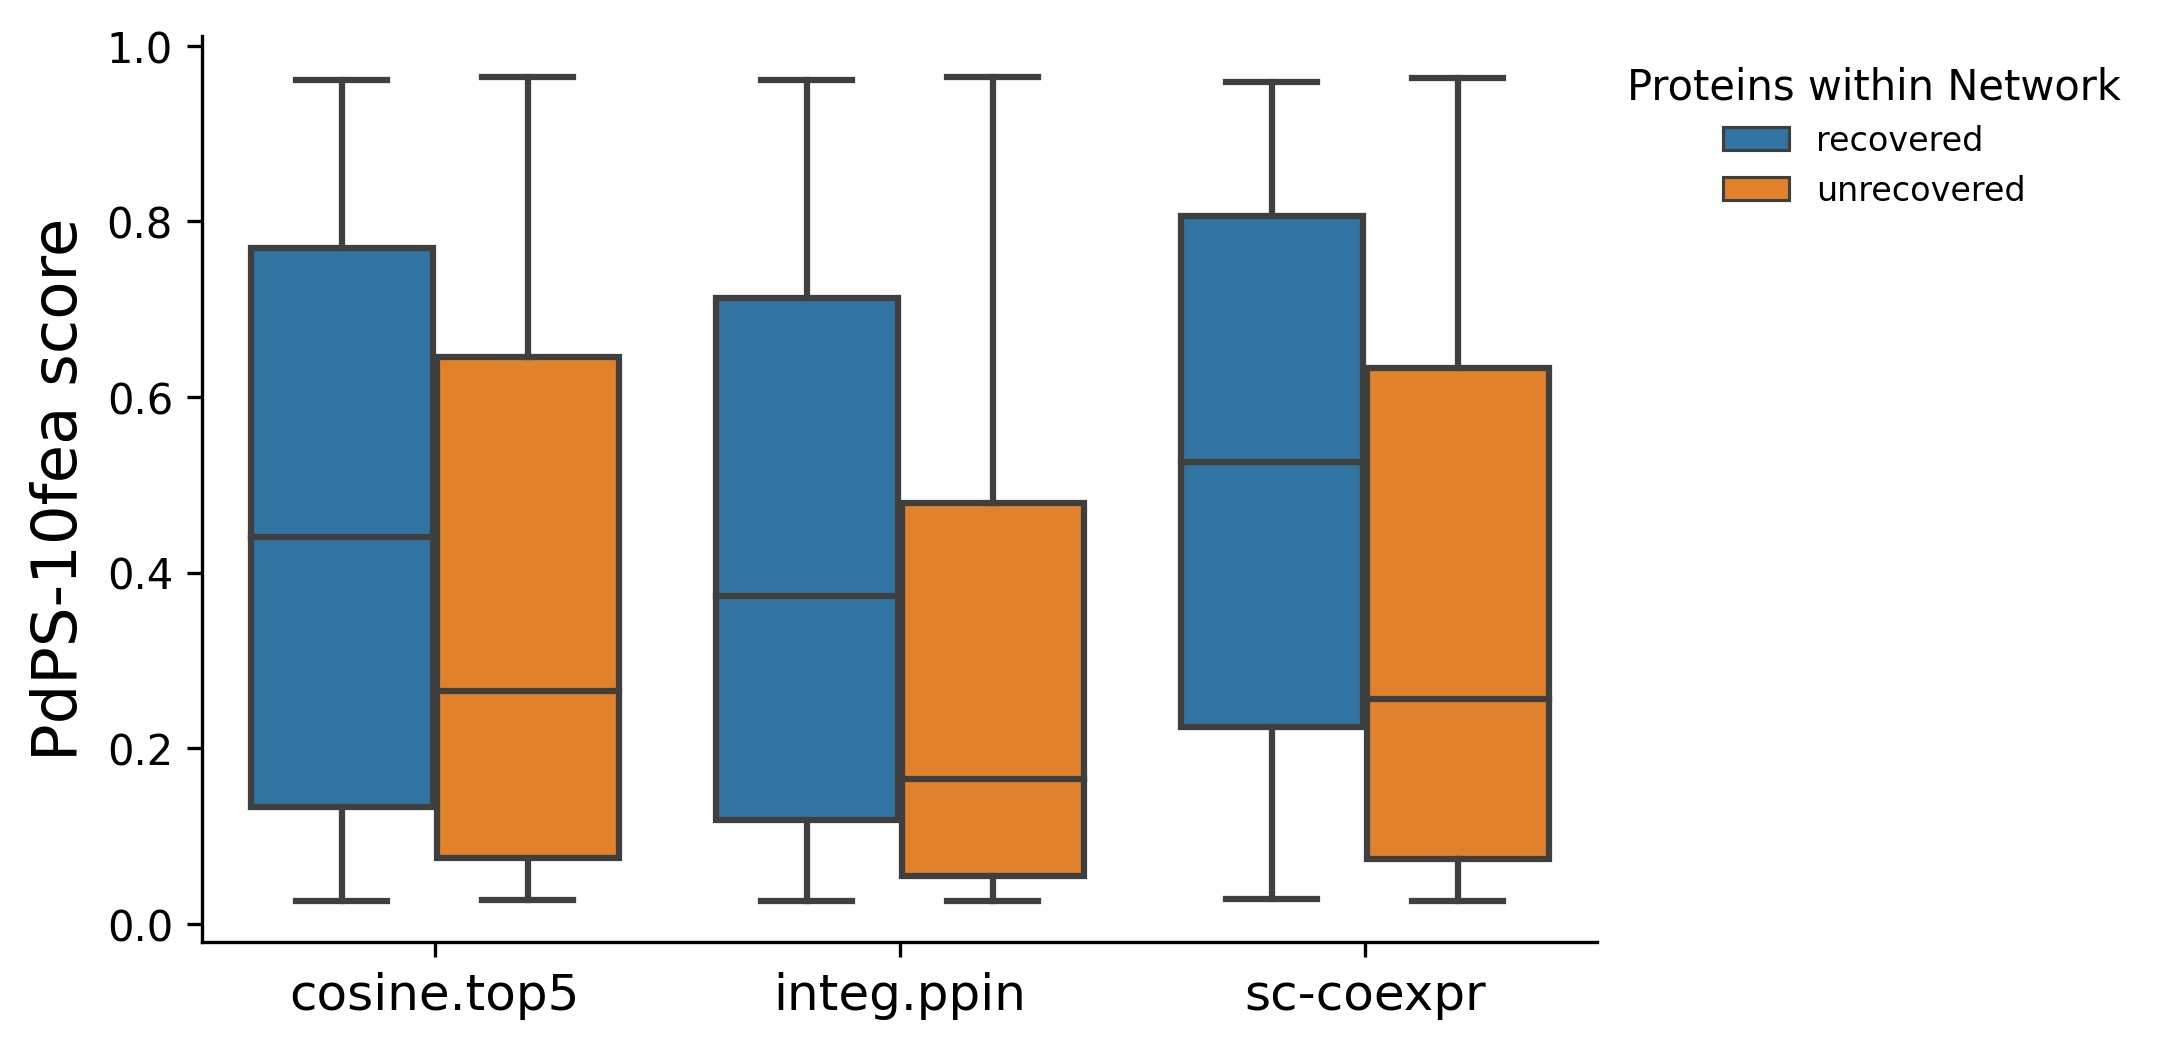

In [751]:
fig, ax = plt.subplots()

sns.boxplot(
    x = 2,
    y = 1,
    hue = 0,
    data = recall_pdps_df,
    ax = ax
)
ax.set_xlabel(None)
ax.set_ylabel('PdPS-10fea score', size=15)
ax.set_xticklabels(name2net_dict.keys(), size=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles, 
    ['recovered', 'unrecovered'],
    bbox_to_anchor = [1, 1],
    title = 'Proteins within Network',
    frameon = False,
    fontsize = 8
)

In [ ]:
"""
for key, val in name2net_dict.items():
    pd.Series(list(set(val[0]))).to_csv(f'./{key}_edge_list.txt', index=None, header=None)
pd.Series(list(set(edge_df['c']))).to_csv(f'./INTEGRATED_NETWORK_edge_list.txt', index=None, header=None)
"""

In [752]:
num1 = len(set(edge_df['c']) - set(rec_df[0]))
num2 = len(set(rec_df[0]))
print(f'The number of new edges in INTEGRATED NETWORK: {num1}, original edges in INTEGRATED NETWORK: {num2}')

The number of new edges in INTEGRATED NETWORK: 1209, original edges in INTEGRATED NETWORK: 15919


## 相分离蛋白之间的边是否变多了

In [753]:
edge_df.loc[(edge_df['A'].isin(lt)) & (edge_df['B'].isin(lt)), 'type'] = 'ps'
edge_df['type'] = edge_df['type'].fillna('nc')

In [754]:
r1 = edge_df[edge_df['type']=='ps'].shape[0] / edge_df.shape[0]
r2 = edges[edges['label']==1].shape[0] / edges.shape[0]

In [755]:
print('The fraction of ps-ppi in INTEGRATED NETWORK: {:.3f}, in ORIGINAL NETWORK: {:.3f}'.format(r1, r2))

The fraction of ps-ppi in INTEGRATED NETWORK: 0.012, in ORIGINAL NETWORK: 0.012


## 相变蛋白之间的edge weights

In [756]:
val1, val2 = edge_df[edge_df['type']=='ps']['w'], edge_df[edge_df['type']=='nc']['w']
from scipy.stats import mannwhitneyu
_, p = mannwhitneyu(val1, val2, alternative='greater')
print(np.median(val1), np.median(val2), p)

0.5563965517832834 0.6007574425426172 0.9999996452939309


## 新添加的edges在pred condensate中是富集的

In [774]:
edge_df.loc[edge_df['c'].isin(set(edge_df['c']) - set(rec_df[0])), 'create'] = 'new'
edge_df['create'] = edge_df['create'].fillna('old')

In [793]:
x = cl['Members'][1]
m = x.split(' ')
df = edge_df[(edge_df['A'].isin(m))&(edge_df['B'].isin(m))]['create'].value_counts().to_frame().reset_index()
if 'new' in df['index'].tolist():
    r = df[df['index']=='new']['create'] / df['create'].sum()
    print(r)

1    0.306122
Name: create, dtype: float64


In [796]:
new_rs = list()
for x in cl['Members']:
    m = x.split(' ')
    df = edge_df[(edge_df['A'].isin(m))&(edge_df['B'].isin(m))]['create'].value_counts().to_frame().reset_index()
    if 'new' in df['index'].tolist():
        r = df[df['index']=='new']['create'] / df['create'].sum()
        new_rs.append(r.item())
    else:
        new_rs.append(0)

In [799]:
cl['new.edges.ratio'] = new_rs

In [804]:
cl[(cl['enr.pval'] < .01)].sort_values(by=['avg.PdPS-10fea', 'new.edges.ratio', 'P-value'], ascending=[False, False, True])

,Cluster,Size,Density,Internal weight,External weight,Quality,P-value,Members,enr.pval,avg.PdPS-10fea,new.edges.ratio
0,1,4,0.5639,3.383,21.8700,0.1017,0.903035,P06748 P60866 Q00839 P22087,3.246803e-04,0.899076,0.000000
116,117,3,0.3460,1.038,0.0000,0.1475,0.031801,O95931 Q06587 Q99496,5.590361e-03,0.804903,0.000000
144,145,8,0.3125,8.750,17.3400,0.2079,0.280314,O75152 Q92900 O43347 Q12926 Q1KMD3 Q14671 Q8TB...,3.981746e-03,0.780317,0.000000
28,29,9,0.3154,11.350,15.2700,0.2544,0.106997,O75152 Q92900 Q12926 Q1KMD3 O60306 Q14671 Q8TB...,5.779233e-03,0.755643,0.000000
1,2,20,0.1538,29.230,23.1900,0.3162,0.000276,O15446 P62807 Q9GZS1 P09874 P49450 Q13185 Q9UK...,6.181572e-08,0.754615,0.306122
73,74,44,0.3013,285.000,303.0000,0.4216,0.000002,Q7Z6E9 Q9UKV3 O15479 Q13243 Q14562 Q8IY81 Q9BU...,2.657923e-07,0.728378,0.008230
137,138,8,0.3172,8.883,13.1400,0.2336,0.110117,P35658 P52948 P49792 O14715 P18754 P57740 Q8NF...,3.981746e-03,0.719992,0.000000
143,144,22,0.1696,39.180,102.6000,0.2109,0.018147,Q14562 Q9BUQ8 P62899 Q8IX18 O15446 P62807 Q017...,2.836670e-04,0.704330,0.272727
139,140,8,0.3172,8.881,13.1400,0.2336,0.110117,P35658 P52948 P49792 O14715 P18754 P57740 Q8NF...,3.981746e-03,0.675057,0.000000
138,139,8,0.3166,8.864,13.1600,0.2332,0.110117,P35658 P52948 P49792 O14715 P18754 P57740 Q8NF...,3.981746e-03,0.674913,0.000000


In [ ]:
"""
array1 = embeds.to_numpy()
array2 = array1.T
array_dot = np.dot(array1, array2)

adjmat = np.array(array_dot >= .5, dtype=np.int)

import networkx as nx
def get_graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    g = nx.Graph()
    g.add_edges_from(edges)
    return g

g = get_graph(adjmat)

edge_df = pd.DataFrame(g.edges)

index2entry_dict = dict(zip(np.arange(len(embeds.index)), embeds.index))
edge_df['A'] = edge_df[0].map(index2entry_dict)
edge_df['B'] = edge_df[1].map(index2entry_dict)

weights_df = pd.DataFrame(array_dot)
weights_df.columns = embeds.index.tolist()
weights_df.index = embeds.index.tolist()

from tqdm import tqdm
edge_weights = list()
for _, i in tqdm(edge_df.iterrows()):
    a, b = i['A'], i['B']
    w = weights_df[a][b]
    # print(a, b, w)
    edge_weights.append(w)

edge_df['w'] = edge_weights

edge_df[['A', 'B', 'w']].to_csv('./scNet.B.txt', sep=' ', index=None, header=None)
"""